In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dsetPath = '/home/pedro/datasets/ub_herbarium/occurrence.txt'

In [209]:
cols = ['recordedBy', 'scientificName', 'family', 'genus', 'species','taxonRank', 
        'stateProvince', 'locality', 'municipality', 'occurrenceRemarks',
        'decimalLatitude','decimalLongitude','issue','hasGeospatialIssues', 'hasCoordinate',
        'eventDate', 'identifiedBy']
occs = pd.read_table(dsetPath, delimiter='\t', usecols=cols, low_memory=False)
occs.dropna(subset=['recordedBy','scientificName'], inplace=True)

In [210]:
occs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185301 entries, 0 to 185310
Data columns (total 17 columns):
recordedBy             185301 non-null object
occurrenceRemarks      140768 non-null object
eventDate              181254 non-null object
stateProvince          174285 non-null object
municipality           135291 non-null object
locality               163029 non-null object
decimalLatitude        185301 non-null float64
decimalLongitude       185301 non-null float64
identifiedBy           148600 non-null object
scientificName         185301 non-null object
family                 182987 non-null object
genus                  176755 non-null object
taxonRank              185301 non-null object
issue                  185301 non-null object
hasCoordinate          185301 non-null object
hasGeospatialIssues    185301 non-null object
species                152360 non-null object
dtypes: float64(2), object(15)
memory usage: 25.4+ MB


In [211]:
occs.head()

,recordedBy,occurrenceRemarks,eventDate,stateProvince,municipality,locality,decimalLatitude,decimalLongitude,identifiedBy,scientificName,family,genus,taxonRank,issue,hasCoordinate,hasGeospatialIssues,species
0,"Irwin, HS","Ascending subshrub 0,3m. Fruit gray-green; Cer...",1972-01-16T01:00Z,Goiás,NaN,"Serra dos Pireneus, ca. 20km E of Pirenópolis",0.000000,0.000000,NaN,Annona monticola Mart.,Annonaceae,Annona,SPECIES,ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...,True,True,Annona monticola
1,"Ratter, JA; et al.",Coppice branches sprouting from the stump of a...,1976-06-30T01:00Z,Minas Gerais,NaN,"Near Pandeiros, ca. 30.0 km W of Januária",0.000000,0.000000,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...,True,True,Myracrodruon urundeuva
2,"Heringer, EP",NaN,1954-06-05T01:00Z,Minas Gerais,NaN,Fazenda do Rasgão. Terreno de cultura,0.000000,0.000000,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...,True,True,Myracrodruon urundeuva
3,"Coelho, JP","Pouco frequente, sem folhas nesse período; Árv...",1964-10-15T01:00Z,Minas Gerais,NaN,IPEACO- Sete lagoas,0.000000,0.000000,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...,True,True,Myracrodruon urundeuva
4,"Eiten, G; Eiten, LT","Tree 5.0 m. tall, 11.0 cm d.b.h. With young fr...",1963-08-17T01:00Z,Maranhão,Loreto,"Ilha de Balsas region, between the Balsas and ...",-7.383333,-45.666667,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,GEODETIC_DATUM_ASSUMED_WGS84;IDENTIFIED_DATE_U...,True,False,Myracrodruon urundeuva


In [176]:
occs.shape[0]

185301

In [177]:
counts = pd.DataFrame(occs['taxonRank'].value_counts())
counts.columns = ['Counts']
counts['Perc'] = counts['Counts']/counts['Counts'].sum()
counts

,Counts,Perc
SPECIES,140763,0.759645
GENUS,24397,0.131661
VARIETY,8935,0.048219
FAMILY,6223,0.033583
KINGDOM,2008,0.010836
SUBSPECIES,1681,0.009072
FORM,1000,0.005397
PHYLUM,294,0.001587


### Spatial Distribution

What is the percentage of records with coordinates?

In [213]:
occs['hasCoordinate'].value_counts()

True    185301
Name: hasCoordinate, dtype: int64

All records have coordinates. But how many of them are free of issues?

What is the percentage of records with geospatial issues?

In [203]:
occs['hasGeospatialIssues'].value_counts()

False    96085
True     89216
Name: hasGeospatialIssues, dtype: int64

In [172]:
89216/(96085+89216)

0.4814652916066292

Around 48% of the selected records have some geospatial issues, which were identified during GBIF platform internal preprocessing routines. 
Records where geographical coordinates have been interpreted to have a geospatial issue are tagged and made available to the data user in the `issue` field.
For geospatial issues the user can also consult the `hasGeospatialIssue` field of the dataset, for making it easier to filter out records with geospatial issues.
By inspecting the `issue` field we can verify that most records with geospatial issues are tagged so because a zero latitude and longitude were assigned to it, which is highly likely to be a missing value.

In [244]:
from collections import Counter

issues = occs[occs['hasGeospatialIssues']==True]['issue'].apply(lambda x: x.split(';'))
issues = pd.DataFrame.from_dict(Counter( v for values in issues.values for v in values ),orient='index')

In [248]:
issues

,0
ZERO_COORDINATE,89109
GEODETIC_DATUM_ASSUMED_WGS84,89216
COUNTRY_COORDINATE_MISMATCH,89134
IDENTIFIED_DATE_UNLIKELY,29918
TAXON_MATCH_HIGHERRANK,4341
TAXON_MATCH_FUZZY,1122
COUNTRY_INVALID,50


In [249]:
issues.loc[['ZERO_COORDINATE','COUNTRY_COORDINATE_MISMATCH']]

,0
ZERO_COORDINATE,89109
COUNTRY_COORDINATE_MISMATCH,89134


In [261]:
occs_w_issues = occs[occs['hasGeospatialIssues']==True]

a = sum(occs_w_issues['issue'].apply(lambda x: 'ZERO_COORDINATE' in x and 'COUNTRY_COORDINATE_MISMATCH' in x))
b = sum(occs_w_issues['issue'].apply(lambda x: 'ZERO_COORDINATE' in x and 'COUNTRY_COORDINATE_MISMATCH' not in x))
c = sum(occs_w_issues['issue'].apply(lambda x: 'ZERO_COORDINATE' not in x and 'COUNTRY_COORDINATE_MISMATCH' in x))
d = sum(occs_w_issues['issue'].apply(lambda x: 'ZERO_COORDINATE' not in x and 'COUNTRY_COORDINATE_MISMATCH' not in x))

In [266]:
c

107

In [ ]:
occs.apply(lambda x: 'Z)

In [46]:
from mpl_toolkits.basemap import Basemap

/home/pedro/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/pedro/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/pedro/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


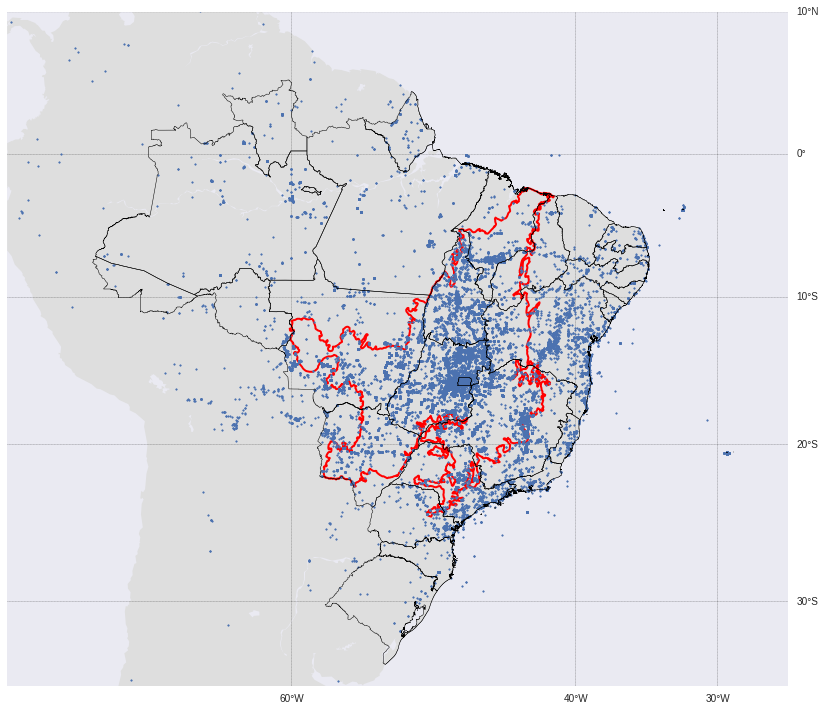

In [419]:
plt.figure(figsize=(14,14))

myMap = Basemap(projection='merc',
                    urcrnrlat=10, urcrnrlon=-25, 
                    llcrnrlat=-35, llcrnrlon=-80,
                    lat_ts=20, resolution='l')

myMap.fillcontinents(color='0.87')
myMap.drawparallels([-60,-40,-30,-20,-10,0,10,20,30],labels=[0,1,0,0],linewidth=0.3)
myMap.drawmeridians([-60,-40,-30], labels=[0,0,0,1],linewidth=0.3)

myMap.readshapefile('../../shapefiles/BRA_adm1', 'states', drawbounds=True, color='0', linewidth=0.5, zorder=10)
myMap.readshapefile('../../shapefiles/biomas2/bioma', 'biomes', drawbounds=False)


for shape,info in zip(myMap.biomes,myMap.biomes_info):
    if info['NOME']=='Cerrado':
        x,y = zip(*shape)
        myMap.plot(x, y, marker=None, color='r',linewidth=2)

records_noissues = occs[occs['hasGeospatialIssues']==False]
records_coords = records_noissues[['decimalLatitude','decimalLongitude']]
x,y = myMap(records_coords['decimalLongitude'].values, records_coords['decimalLatitude'].values)

myMap.plot(x,y,'o', markeredgewidth=0.6, ms=1.5)

plt.savefig('/home/pedro/Downloads/map.png',dpi=192,format='png',bbox_inches='tight')

/home/pedro/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


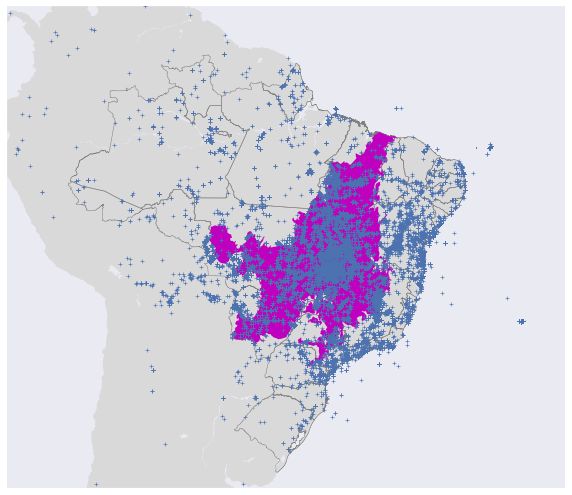

In [364]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

myMap = Basemap(projection='merc',
                    urcrnrlat=10, urcrnrlon=-25, 
                    llcrnrlat=-35, llcrnrlon=-80,
                    lat_ts=20, resolution='l')

myMap.fillcontinents(color='0.85')

myMap.readshapefile('../../shapefiles/BRA_adm1', 'states', drawbounds=True, color='0.5')
myMap.readshapefile('../../shapefiles/biomas2/bioma', 'biomes', drawbounds=False, color='0.5')

patches=[]

for info,shape in zip(myMap.biomes_info, myMap.biomes):
    if info['NOME']=="Cerrado":
        patches.append( Polygon(np.array(shape),True) )
        
ax.add_collection(PatchCollection(patches,facecolor='m', zorder=2))

records_noissues = occs[occs['hasGeospatialIssues']==False]
records_coords = records_noissues[['decimalLatitude','decimalLongitude']]
x,y = myMap(records_coords['decimalLongitude'].values, records_coords['decimalLatitude'].values)
ax.plot(x,y,'+', markeredgewidth=0.6,ms=4)

plt.show()    



### Temporal distribution

In [23]:
occs_ts = occs.set_index(pd.to_datetime(occs['eventDate']))
occs_ts.sort_index(inplace=True)

How many records per year?

In [101]:
recs_per_year = occs_ts['scientificName'].resample('AS').count()

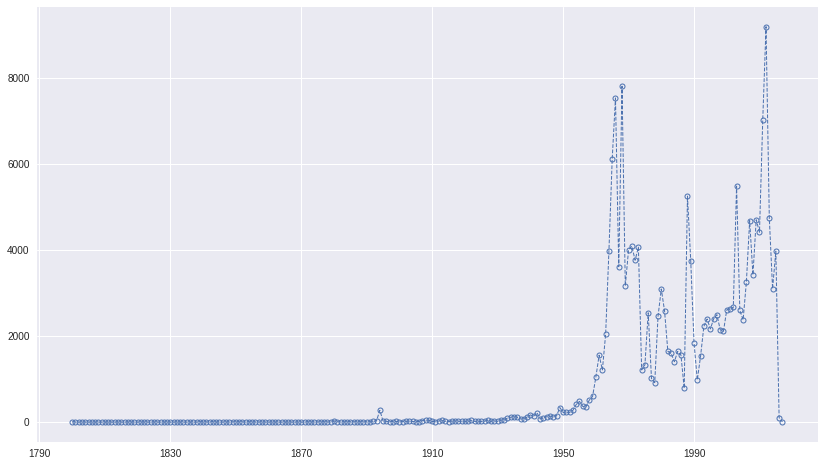

In [112]:
plt.figure(figsize=(14,8))
plt.plot(recs_per_year, 'o',markerfacecolor='none', markeredgewidth=1, ms=5,ls='--',lw=1)

In [103]:
occs_ts['2016']

,recordedBy,occurrenceRemarks,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,genus,taxonRank,species
eventDate,,,,,,,,,,,,
2016-01-02 01:00:00,"Faria, JEQ",Erva cespitosa 1m; espiguetas verdes; Cerrado ...,2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...",NaN,Paspalum L.,Poaceae,Paspalum,GENUS,NaN
2016-01-02 01:00:00,"Faria, JEQ","Subarbusto ca. 0,8 m de altura, frutos imaturo...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...","Faria, JEQ",Psidium luridum (Spreng.) Burret,Myrtaceae,Psidium,SPECIES,Psidium salutare
2016-01-02 01:00:00,"Faria, JEQ","Erva ca. 0,4 m de altura, espiguetas castanhas...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...",NaN,Cyperaceae,Cyperaceae,NaN,FAMILY,NaN
2016-01-02 01:00:00,"Faria, JEQ","Erva ca. 0,2 m de altura, espiguetas castanhas...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...",NaN,Cyperaceae,Cyperaceae,NaN,FAMILY,NaN
2016-01-02 01:00:00,"Faria, JEQ","Arvoreta ca. 3 m de altura, botões florais ver...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...","Faria, JEQ",Ferdinandusa elliptica (Pohl) Pohl,Rubiaceae,Ferdinandusa,SPECIES,Ferdinandusa elliptica
2016-01-02 01:00:00,"Faria, JEQ","Árvore ca. 12 m de altura, frutos imaturos ver...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...","Proença, C",Priogymnanthus hasslerianus (Chodat) P.S.Green,Oleaceae,Priogymnanthus,SPECIES,Priogymnanthus hasslerianus
2016-01-02 01:00:00,"Faria, JEQ","Subarbusto ca. 0,3 m de altura, flores rosas; ...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...","Facco, MG",Cuphea spermacoce St.-Hil.,Lythraceae,Cuphea,SPECIES,Cuphea spermacoce
2016-01-02 01:00:00,"Faria, JEQ","Árvore ca. 4 m de altura, frutos imaturos verd...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...",NaN,Psidium hians Mart. ex DC.,Myrtaceae,Campomanesia,SPECIES,Campomanesia pubescens
2016-01-02 01:00:00,"Faria, JEQ","Subarbusto ca. 0,25 m de altura, flores amarel...",2016-01-02T01:00Z,Goiás,Alto Horizonte,"Região da Sururuca, fazenda Cajás, proprietári...",NaN,Camarea A. St.-Hil.,Malpighiaceae,Camarea,GENUS,NaN


In [51]:
occs_ts['1947']

,recordedBy,occurrenceRemarks,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,genus,taxonRank,species
eventDate,,,,,,,,,,,,
1947-01-01 01:00:00,"Pires, JM",NaN,1947-01-01T01:00Z,Pará,NaN,"Tomé-açú, Rio pequeno, afluente do Rio Acará.",Incógnito,Lacunaria jenmanii (Oliv.) Ducke,Quiinaceae,Lacunaria,SPECIES,Lacunaria jenmanii
1947-01-01 01:00:00,"Stokoe, TP",NaN,1947-01-01T01:00Z,NaN,NaN,"Swartberg Pass, Prince Albert area","Câmara, PEAS",Sematophyllum gueinzii (Hampe) Magill,Sematophyllaceae,Sematophyllum,SPECIES,Sematophyllum gueinzii
1947-01-01 01:00:00,"Pires, JM",NaN,1947-01-01T01:00Z,Pará,NaN,"Tomé-açú, Rio pequeno, afluente do Rio Acará.",Incógnito,Lacunaria jenmanii (Oliv.) Ducke,Quiinaceae,Lacunaria,SPECIES,Lacunaria jenmanii
1947-01-11 01:00:00,"Risso, JL","Plan ""Genera et Species Plantarum Argentinarum.",1947-01-11T01:00Z,Catamarca,NaN,Villa Santo Domingo. Los Angeles. Dep. Capayán,NaN,Oxalis L.,Oxalidaceae,Oxalis,GENUS,NaN
1947-01-13 01:00:00,"Malvarez, MR",NaN,1947-01-13T01:00Z,Salta,Salta,Dep. Anta. General Pizarro.,NaN,Oxalis L.,Oxalidaceae,Oxalis,GENUS,NaN
1947-01-14 01:00:00,"Hoehne, W","Slender shrub 0,3m tall.",1947-01-14T01:00Z,São Paulo,NaN,Próximo a São Miguel.,NaN,Chaetostoma pungens DC.,Melastomataceae,Chaetostoma,SPECIES,Chaetostoma armatum
1947-01-15 01:00:00,"Malvárez, R","Plan ""Genera et Species Plantarum Argentinarum.",1947-01-15T01:00Z,Salta,Salta,Dep. Anta. General Mollinedo.,NaN,Oxalis erosa Knuth,Oxalidaceae,Oxalis,SPECIES,Oxalis erosa
1947-01-19 01:00:00,"Borsini, OH","Plan ""Genera et Species Plantarum Argentinarum.",1947-01-19T01:00Z,Tucumán,NaN,"Dep. Burruyacú. Estância Los pinos, Rodeo de l...",NaN,Oxalis L.,Oxalidaceae,Oxalis,GENUS,NaN
1947-01-20 01:00:00,"Clover, EU",NaN,1947-01-20T01:00Z,NaN,NaN,High hill E of Jalapa,"Allen, BH",Sematophyllum Mitt.,Sematophyllaceae,Sematophyllum,GENUS,NaN
